## Problem Statement: BBC wants to auto categorize the news into various categories which will also help in recommending the right news articles to it users at a later stage.

In [3]:
import pandas as pd
import numpy as np
from IPython.display import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import re
import matplotlib.pyplot as plt

In [4]:
# Reading DataSet
df = pd.read_csv("/content/bbc-news-data.csv", sep="\t")
df

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...


**Attribute information:**
- filename - name of the file for that news.
- title - the headline of the news
- content - main news content.
- category - target variable that describes the type of a news item.


In [5]:
# Dropping the empty Titles
print(df.shape)
df = df[((~df.title.isnull()) & (~df.content.isnull()))].reset_index(drop=True)
print(df.shape)

df

(2225, 4)
(2225, 4)


,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...


Text(0, 0.5, 'Count')

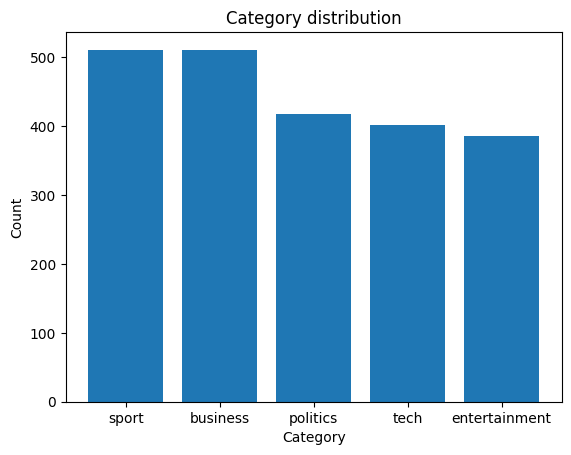

In [6]:
# Visualizing distribution of Category
plt.bar(df.category.value_counts().index, df.category.value_counts().values)
plt.title('Category distribution')
plt.xlabel("Category")
plt.ylabel("Count")

In [7]:
# Visualizing Sample data
ind=123
print(f'Title: {df.title[ind]}')
print(f'Category: {df.category[ind]}')

Title: Bargain calls widen Softbank loss
Category: business


In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, InputLayer, RNN, SimpleRNN, LSTM, GRU, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import string

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
def data_cleaning(text):

    # Lower the words in the sentence
    cleaned = text.lower()

    # Replace the full stop with a full stop and space
    cleaned = cleaned.replace(".", ". ")

    # Remove the stop words
    tokens = [word for word in cleaned.split() if not word in stop_words]

    # Remove the punctuations
    tokens = [tok.translate(str.maketrans(' ', ' ', string.punctuation)) for tok in tokens]

    # Joining the tokens back to form the sentence
    cleaned = " ".join(tokens)

    # Remove any extra spaces
    cleaned = cleaned.strip()

    return cleaned


In [10]:
for index, data in tqdm(df.iterrows(), total=df.shape[0]):
    df.loc[index, 'title'] = data_cleaning(data['title'])

100%|██████████| 2225/2225 [00:00<00:00, 7445.86it/s]


In [12]:
# Getting Maximum length of sentence
max_sentence_len = df['title'].str.split(" ").str.len().max()
total_classes = df.category.nunique()

print(f"Maximum sequence length: {max_sentence_len}")
print(f"Total classes: {total_classes}")

Maximum sequence length: 7
Total classes: 5


In [13]:
# Train Test Splitting
np.random.seed(42)
train_X, test_X, train_Y, test_Y = train_test_split(df['title'],
                                                    df['category'],
                                                    test_size=0.2,
                                                    random_state=42)
train_X = train_X.reset_index(drop=True)
test_X = test_X.reset_index(drop=True)
train_Y = train_Y.reset_index(drop=True)
train_Y = train_Y.reset_index(drop=True)

In [14]:
train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

((1780,), (1780,), (445,), (445,))

In [15]:
# OHE labels
train_Y = pd.get_dummies(train_Y).values
test_Y = pd.get_dummies(test_Y).values

In [16]:
validation = test_Y.argmax(axis=1)

In [17]:
# Tokenization
def tokenize_and_pad(inp_text, max_len, tok):

    text_seq = tok.texts_to_sequences(inp_text)
    text_seq = pad_sequences(text_seq, maxlen=max_len, padding='post')

    return text_seq

text_tok = Tokenizer()
text_tok.fit_on_texts(train_X)
train_text_X = tokenize_and_pad(inp_text=train_X, max_len=max_sentence_len, tok=text_tok)
test_text_X = tokenize_and_pad(inp_text=test_X, max_len=max_sentence_len, tok=text_tok)
vocab_size = len(text_tok.word_index)+1

print("Overall text vocab size", vocab_size)

Overall text vocab size 3378


In [23]:
train_Y

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0]], dtype=uint8)

In [18]:
# Defining weights and Embedding Dimension - Hyper parameters
latent_dim=70
embedding_dim=120

In [19]:
# Model Building
seed=56
tf.random.set_seed(seed)
np.random.seed(seed)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, trainable=True))
model.add(SimpleRNN(latent_dim, recurrent_dropout=0.2, return_sequences=False, activation='tanh'))
model.add(Dense(total_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 120)         405360    
                                                                 
 simple_rnn (SimpleRNN)      (None, 70)                13370     
                                                                 
 dense (Dense)               (None, 5)                 355       
                                                                 
Total params: 419085 (1.60 MB)
Trainable params: 419085 (1.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
# Model Compiling and Training
import datetime

tf.random.set_seed(seed)
np.random.seed(seed)

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc',
                               mode='max',
                               verbose=1,
                               patience=5)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=train_text_X, y=train_Y,
          validation_data=(test_text_X, test_Y),
          batch_size=64,
          epochs=10,
          callbacks=[early_stopping, tensorboard_callback])

Epoch 1/10
28/28 [==============================] - 11s 205ms/step - loss: 1.5662 - acc: 0.2876 - val_loss: 1.5295 - val_acc: 0.3236
Epoch 2/10
28/28 [==============================] - 1s 54ms/step - loss: 1.1639 - acc: 0.5876 - val_loss: 1.2175 - val_acc: 0.6180
Epoch 3/10
28/28 [==============================] - 1s 50ms/step - loss: 0.4887 - acc: 0.8618 - val_loss: 1.0385 - val_acc: 0.6876
Epoch 4/10
28/28 [==============================] - 2s 58ms/step - loss: 0.1917 - acc: 0.9567 - val_loss: 1.0503 - val_acc: 0.7393
Epoch 5/10
28/28 [==============================] - 2s 58ms/step - loss: 0.0882 - acc: 0.9820 - val_loss: 1.1318 - val_acc: 0.7371
Epoch 6/10
28/28 [==============================] - 1s 26ms/step - loss: 0.0521 - acc: 0.9910 - val_loss: 1.1830 - val_acc: 0.7461
Epoch 7/10
28/28 [==============================] - 1s 26ms/step - loss: 0.0311 - acc: 0.9949 - val_loss: 1.2866 - val_acc: 0.7348
Epoch 8/10
28/28 [==============================] - 1s 18ms/step - loss: 0.0182 -

In [26]:
model.save("NLP_classifier.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
prediction = model.predict(test_text_X)
prediction = prediction.argmax(axis=1)
print(f"Accuracy: {accuracy_score(prediction, validation)}")

14/14 [==============================] - 0s 2ms/step
Accuracy: 0.7415730337078652


Text(0.5, 1.0, 'Confusion Matrix')

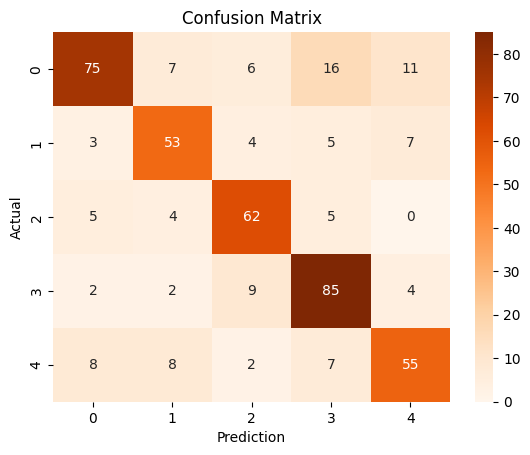

In [28]:
cm = confusion_matrix(validation, prediction)
sns.heatmap(cm, annot=True, cmap='Oranges')
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.title("Confusion Matrix")